In [1]:
import scanpy as sc
adata=sc.read("data/adata_cleaned.h5ad")

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 4568 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



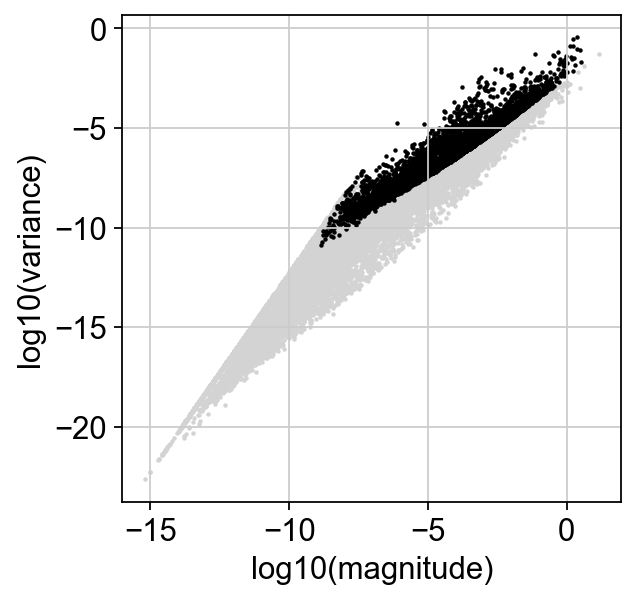

In [2]:
sc.set_figure_params()
import scFates as scf
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e3)
sc.pp.log1p(adata)
scf.pp.find_overdispersed(adata,plot=True,)
adata.layers["scaled"]=sc.pp.scale(adata.X,max_value=10,copy=True)
adata.obsm["X_pca"]=sc.pp.pca(adata[:,adata.var.highly_variable].layers["scaled"])
sc.pp.neighbors(adata,n_neighbors=15,n_pcs=15,metric="cosine")

In [3]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

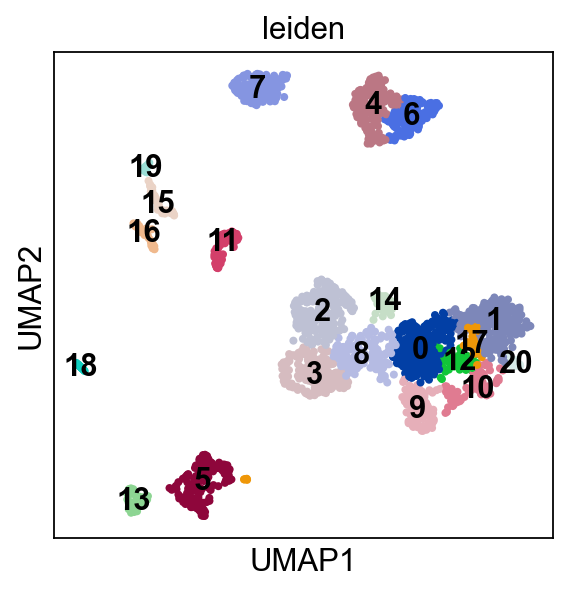

In [4]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

In [5]:
sc.tl.leiden(adata,resolution=1.2)

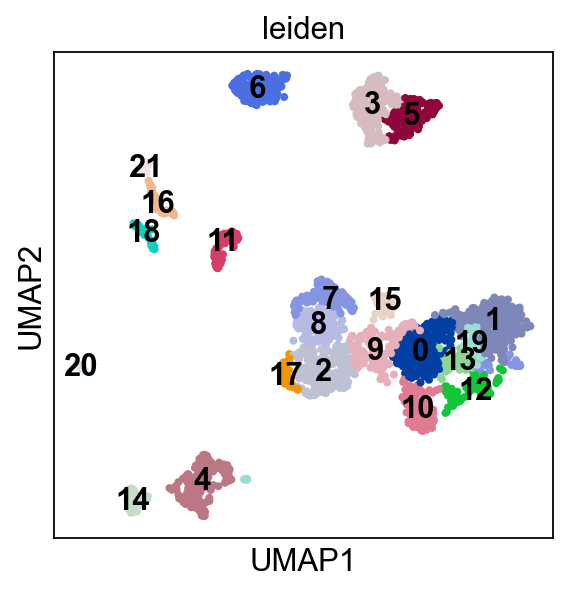

In [6]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

In [7]:
adata.obsm["X_pca"].shape

(2308, 50)

In [8]:
import pandas as pd

In [9]:
tp=adata.obs.devtime
tp=tp.astype(str)  
tp.loc[tp.isin(["E17.5","E18.5"])]="E17-E18.5"
import harmony
timepoint_connections = pd.DataFrame(columns=[0, 1])
index = 0
timepoint_connections.loc[index, :] = ['E14.5', 'E15.5']; index += 1
timepoint_connections.loc[index, :] = ['E15.5', 'E16.5']; index += 1
timepoint_connections.loc[index, :] = ['E16.5', 'E17-E18.5']; index += 1
timepoint_connections.loc[index, :] = ['E17-E18.5', 'P3']; index += 1
timepoint_connections
data_df=pd.DataFrame(adata.obsm["X_pca"][:,:15],index=adata.obs_names)
aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, tp, timepoint_connections,n_neighbors=20,pc_components=None)

import palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
#ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=8)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=10)
ms_data.index = data_df.index
ms_data

adata.obsp["T"]=dm_res["T"]

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Nearest neighbor computation...


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/harmony/core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']


Constucting affinities between E14.5 and E15.5...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E15.5 and E16.5...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E16.5 and E17-E18.5...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E17-E18.5 and P3...
t+1 neighbors of t...
t neighbors of t+1...


In [10]:
adata.obsm["X_msdiff"]=ms_data.values
sc.tl.tsne(adata,use_rep="X_msdiff",perplexity=100,learning_rate=adata.shape[0]/12)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


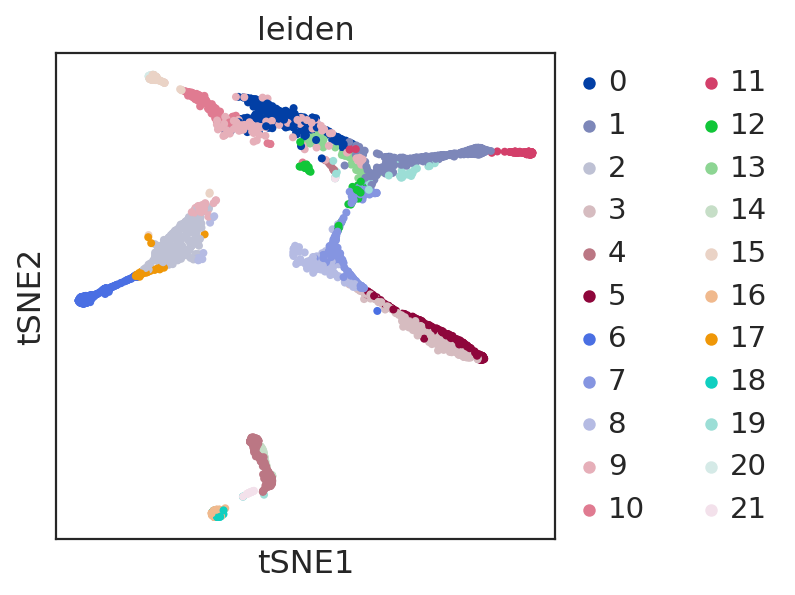

In [11]:
sc.pl.tsne(adata,color="leiden")

In [12]:
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_msdiff")

In [13]:
sc.tl.draw_graph(adata,init_pos="X_tsne",maxiter=500)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


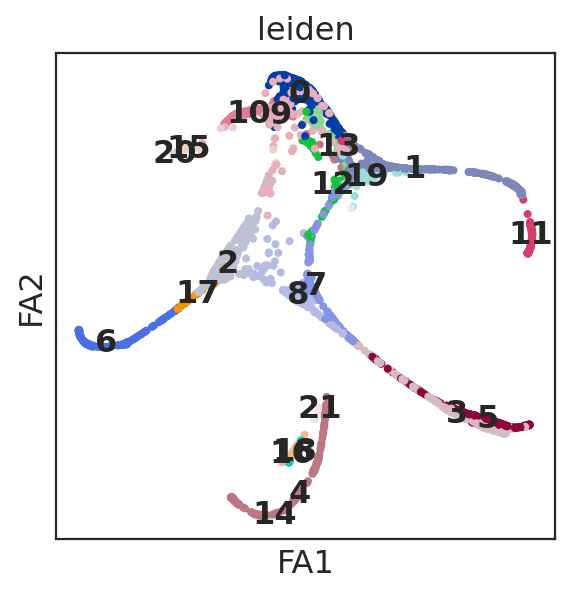

In [14]:
sc.pl.draw_graph(adata,color="leiden",legend_loc="on data")

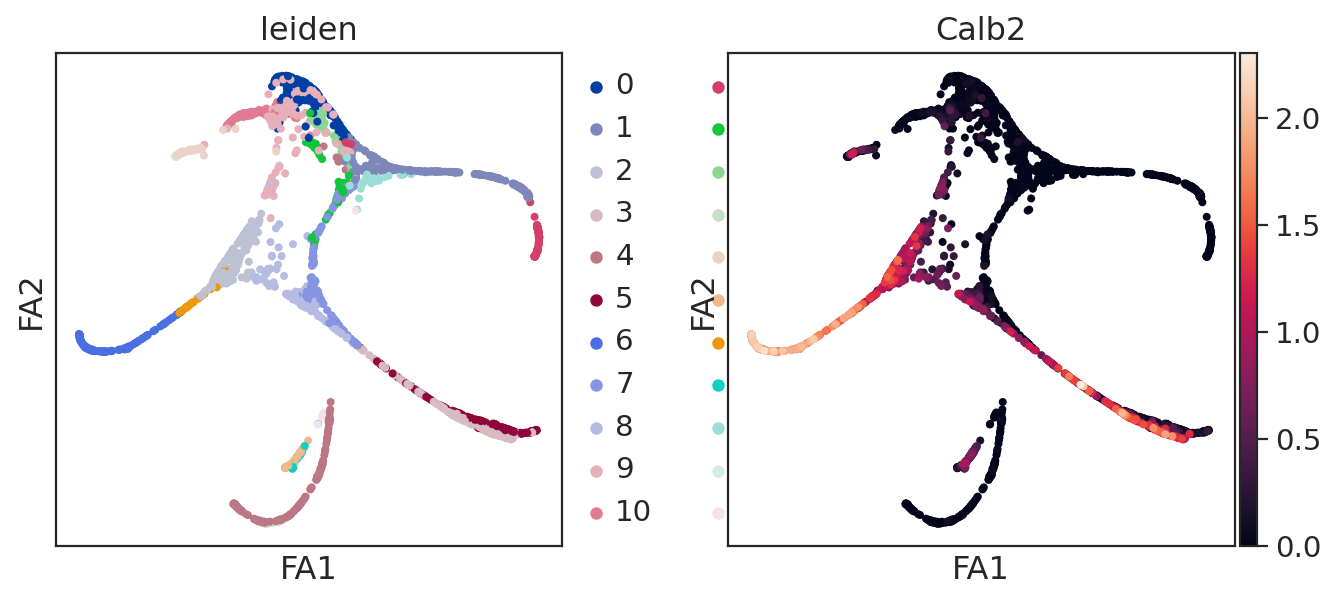

In [15]:
sc.pl.draw_graph(adata,color=["leiden","Calb2"])

In [16]:
adata=adata[adata.obs.leiden!="21"]

In [17]:
from cuml.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
doublets=[]
def get_zscores(c):
    dists=pairwise_distances(adata[adata.obs.leiden==c].obsm["X_draw_graph_fa"])
    return pd.Series(StandardScaler().fit_transform(dists.mean(axis=1).reshape(-1, 1)).ravel(),
         index=adata[adata.obs.leiden==c].obs_names).abs()

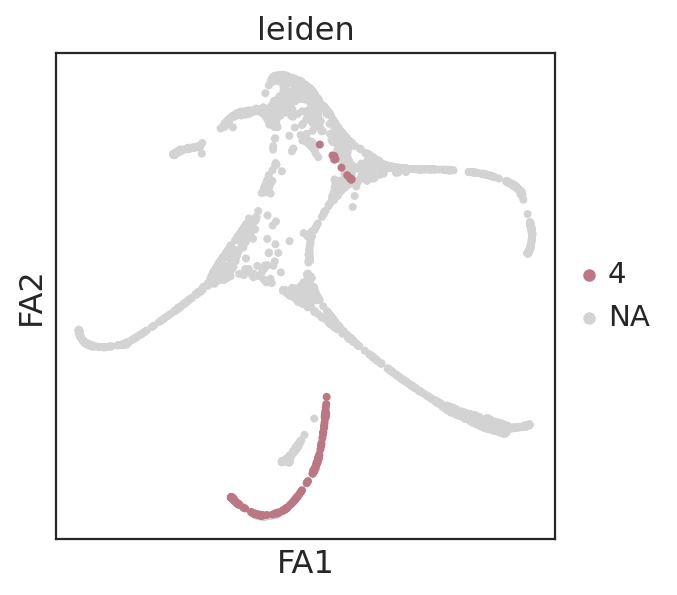

In [18]:
doublets=[]

sc.pl.draw_graph(adata,color="leiden",groups=["4"])
z=get_zscores("4")
doublets=doublets+z.index[z>3].tolist()

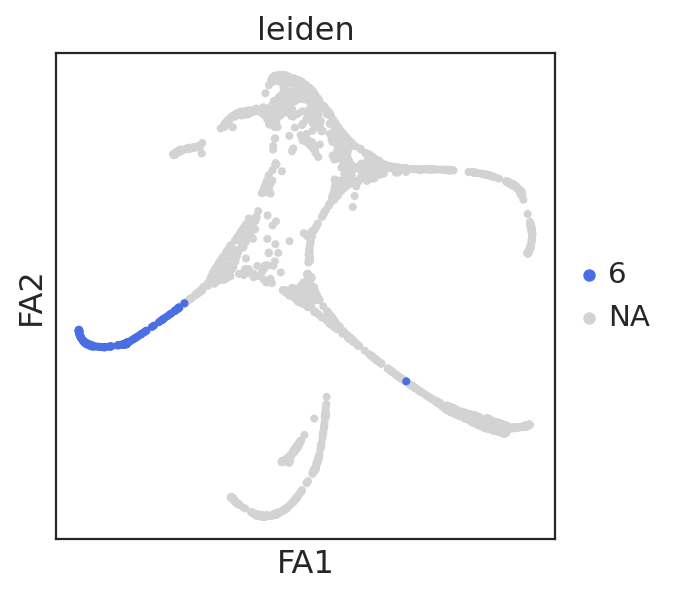

In [19]:
sc.pl.draw_graph(adata,color="leiden",groups=["6"])
z=get_zscores("6")
doublets=doublets+z.index[z>3].tolist()

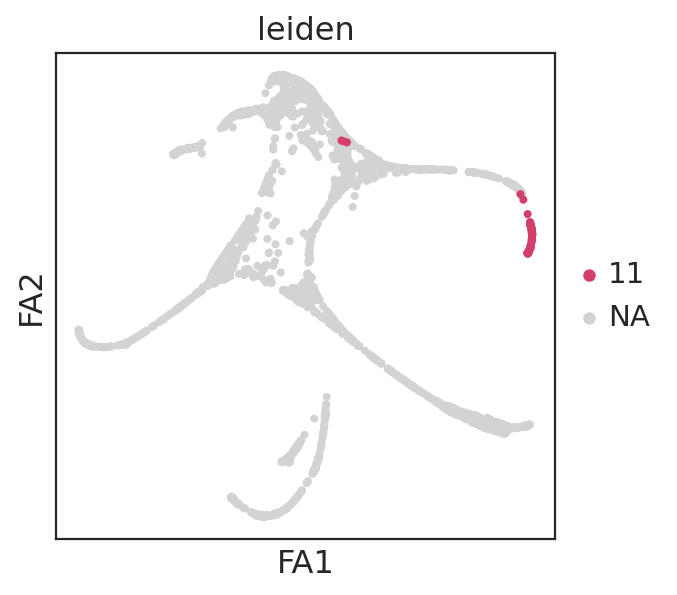

In [20]:
sc.pl.draw_graph(adata,color="leiden",groups=["11"])
z=get_zscores("11")
doublets=doublets+z.index[z>3].tolist()

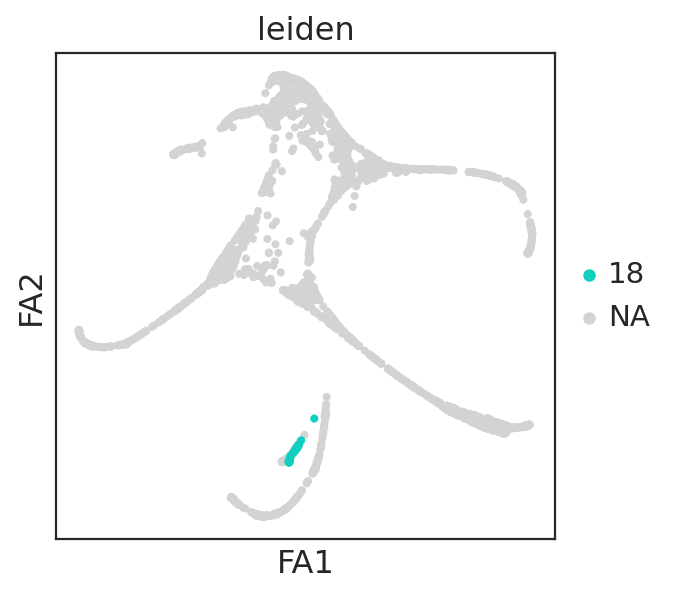

In [21]:
sc.pl.draw_graph(adata,color="leiden",groups=["18"])
z=get_zscores("18")
doublets=doublets+z.index[z>3].tolist()

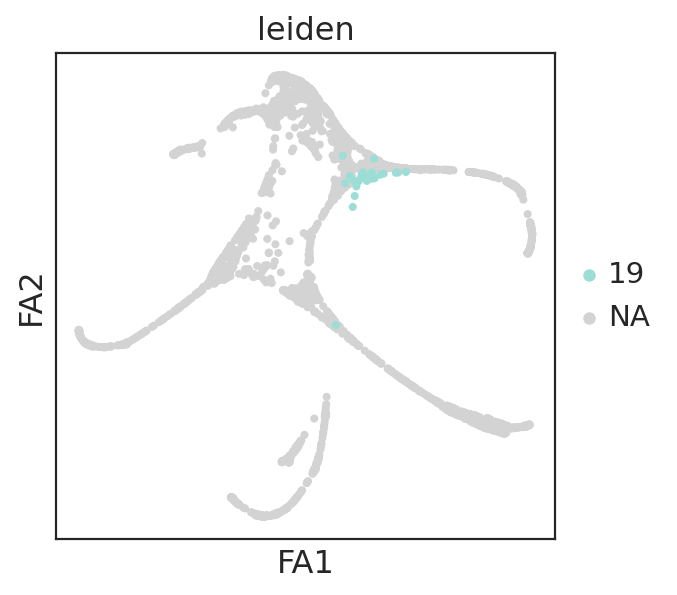

In [22]:
sc.pl.draw_graph(adata,color="leiden",groups=["19"])
z=get_zscores("19")
doublets=doublets+z.index[z>3].tolist()

In [23]:
adata.obs["doublets"]="False"
adata.obs.loc[doublets,"doublets"]="True"

Trying to set attribute `.obs` of view, copying.


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'doublets' as categorical


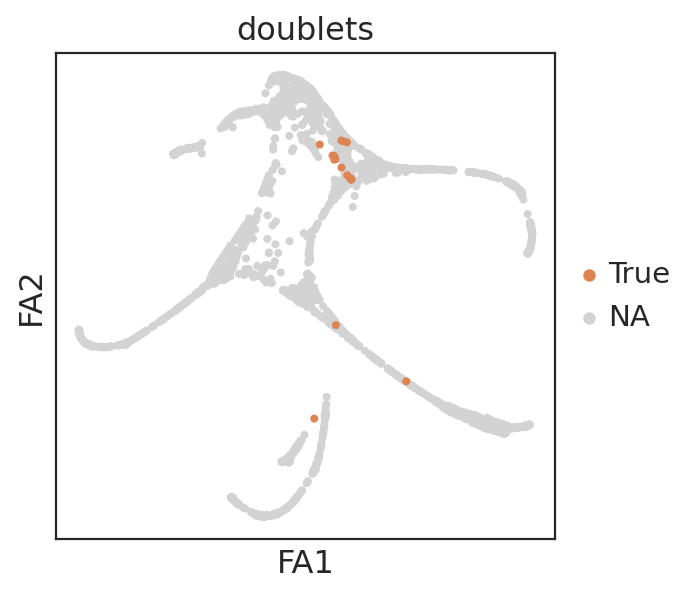

In [24]:
sc.pl.draw_graph(adata,color="doublets",groups=["True"])

In [25]:
adata=adata[adata.obs.doublets=="False"]

In [26]:
del adata.obs["doublets"]

In [27]:
import numpy as np
adata.X=np.expm1(adata.X)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
adata.layers["palantir_imp"]=np.dot((adata.obsp["T"]**3), adata.X)

In [29]:
replace={"11":"1","1":"2","19":"3","12":"4","13":"5","0":"6","9":"7",
                                        "10":"8","15":"9","20":"10","2":"11","17":"12","6":"13",
                                        "8":"14","3":"15","7":"16","5":"17","16":"18",
                                        "4":"19","14":"19"}

In [30]:
adata.obs.leiden=adata.obs.leiden.astype(str).replace(replace.keys(),replace.values()).astype("category")

In [31]:
adata.obs.leiden=adata.obs.leiden.cat.reorder_categories(['1','2', '3', '4', '5', '6', '7', '8', '9',
                                                          '10', '11', '12', '13', '14', '15', '16', '17', '18','19'])

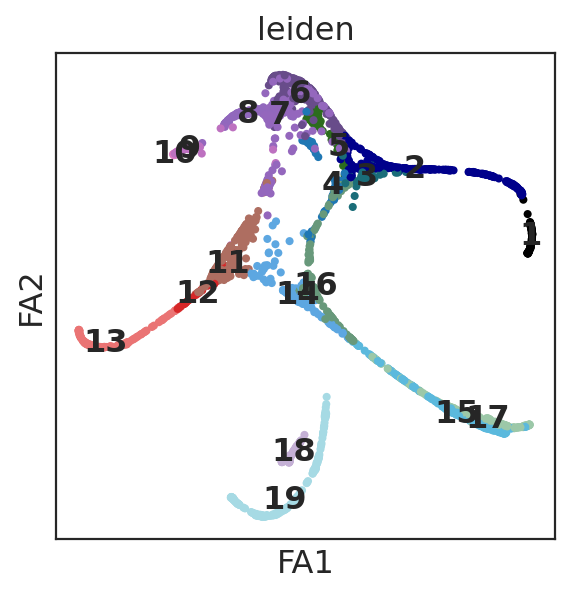

In [66]:
sc.pl.draw_graph(adata,color="leiden",legend_loc="on data",
                 palette=["black","darkblue","#1A6D79","tab:blue","#2C6C1D","#684C8A","tab:purple",
                          '#9168bd', '#bd71c0', '#dc79c2', "#AE6E61", 'tab:red', '#EA7474',
                          '#5da7e1', '#5BB9DD', '#68997B', "#9CC8A8","#C4B0D5","#A6DAE4"])

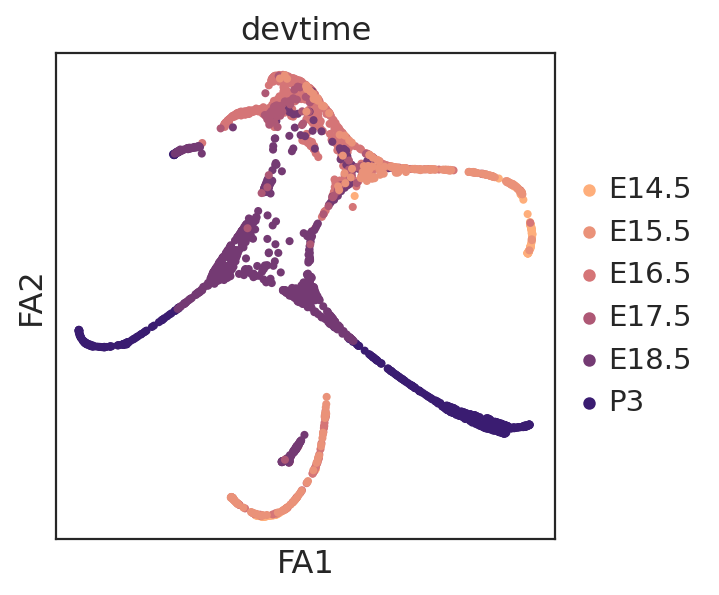

In [33]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import rgb2hex
cmap_dev=LinearSegmentedColormap.from_list("aspect",["#3A1C71","#CB6776","#FEAE7B"])
sc.pl.draw_graph(adata,color="devtime",palette=[rgb2hex(c) for c in cmap_dev(np.linspace(1,0,6))])

In [67]:
adata.write("data/adata_aligned.h5ad")

In [68]:
from anndata2pagoda import pagoda2web
pagoda2web(adata,use_rep="X_draw_graph_fa",
           key_to_include=["leiden","devtime"],
           filename="data/p2w_cleaned.bin")

Converting to pagoda2 web object from anndata: layer X, X_draw_graph_fa embedding, ['leiden', 'devtime'] obs keys
    converting to SingleCellExperiment


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


    generating pagoda2 object
    getting Hierarchical Diff Expression Aspects
    making Gene Knn graph
    saving p2 web bin file
    done! Saved as data/p2w_cleaned.bin


In [69]:
pagoda2web(adata,use_rep="X_draw_graph_fa",layer="palantir_imp",
           key_to_include=["leiden","devtime"],
           filename="data/p2w_cleaned_imputed.bin")

Converting to pagoda2 web object from anndata: layer palantir_imp, X_draw_graph_fa embedding, ['leiden', 'devtime'] obs keys
    converting to SingleCellExperiment
    generating pagoda2 object
    getting Hierarchical Diff Expression Aspects
    making Gene Knn graph
    saving p2 web bin file
    done! Saved as data/p2w_cleaned_imputed.bin


In [70]:
adata=adata[~adata.obs.leiden.isin(["18","19"])]

In [71]:
pagoda2web(adata,use_rep="X_draw_graph_fa",
           key_to_include=["leiden","devtime"],
           filename="data/p2w_sgn.bin")

Converting to pagoda2 web object from anndata: layer X, X_draw_graph_fa embedding, ['leiden', 'devtime'] obs keys
    converting to SingleCellExperiment
    generating pagoda2 object
    getting Hierarchical Diff Expression Aspects
    making Gene Knn graph
    saving p2 web bin file
    done! Saved as data/p2w_sgn.bin


In [72]:
pagoda2web(adata,use_rep="X_draw_graph_fa",layer="palantir_imp",
           key_to_include=["leiden","devtime"],
           filename="data/p2w_sgn_imputed.bin")

Converting to pagoda2 web object from anndata: layer palantir_imp, X_draw_graph_fa embedding, ['leiden', 'devtime'] obs keys
    converting to SingleCellExperiment
    generating pagoda2 object
    getting Hierarchical Diff Expression Aspects
    making Gene Knn graph
    saving p2 web bin file
    done! Saved as data/p2w_sgn_imputed.bin
